# *k*-NN Prediction for Hourly Demand Forecast

##### by Winston Chiong

The contents of this Jupyter Notebook are based off the paper:

***Fast Prediction for Sparse Time Series: Demand Forecast of EV Charging Stations for Cell Phone Applications***

by Mostafa Majidpour, Student Member, IEEE, Charlie Qiu, Peter Chu, Rajit Gadh, Member, IEEE, and Hemanshu R. Pota, Member, IEEE.

Link to paper [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6966759).

The objective is to predict the future (24-hour forecasting horizon) energy consumption based on past energy consumption. 

$\large \hat{E}(t) = f(E(t-i), \epsilon(t)), \hspace{1cm} i \in \{1,2,\dots\}$,

where $\hat{E}(t)$ is the actual energy consumption at time $t$, $\hat{E}(t)$ is the prediction of energy consumption at time $t$, and $\epsilon(t)$ are variables other than past energy consumption, such as noise, that future energy consumption might depend on.

In [116]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from datetime import timedelta
from sklearn.metrics import mean_squared_error

Let's begin by loading our hourly demand dataframe.

In [80]:
hourly_power_demand_df = pd.read_csv("data/hourlypowerdemand11052020-09222022.csv")
hourly_power_demand_df.set_index("time", inplace=True) 
hourly_power_demand_df.index = pd.to_datetime(hourly_power_demand_df.index)
hourly_power_demand_df

power_demand       day  Monday  Tuesday  Wednesday  \
time                                                                      
2020-11-05 10:00:00         25144  Thursday     0.0      0.0        0.0   
2020-11-05 11:00:00         15733  Thursday     0.0      0.0        0.0   
2020-11-05 12:00:00             0  Thursday     0.0      0.0        0.0   
2020-11-05 13:00:00             0  Thursday     0.0      0.0        0.0   
2020-11-05 14:00:00             0  Thursday     0.0      0.0        0.0   
...                           ...       ...     ...      ...        ...   
2022-08-22 13:00:00        232527    Monday     1.0      0.0        0.0   
2022-08-22 14:00:00        251821    Monday     1.0      0.0        0.0   
2022-08-22 15:00:00        186847    Monday     1.0      0.0        0.0   
2022-08-22 16:00:00         12892    Monday     1.0      0.0        0.0   
2022-08-22 17:00:00             0    Monday     1.0      0.0        0.0   

                     Thursday  Friday  Saturday  Sunday  Federal Holiday  \
time                                                                       
2020-11-05 10:00:00       1.0     0.0       0.0     0.0                0   
2020-11-05 11:00:00       1.0     0.0       0.0     0.0                0   
2020-11-05 12:00:00       1.0     0.0       0.0     0.0                0   
2020-11-05 13:00:00       1.0     0.0       0.0     0.0                0   
2020-11-05 14:00:00       1.0     0.0       0.0     0.0                0   
...                       ...     ...       ...     ...              ...   
2022-08-22 13:00:00       0.0     0.0       0.0     0.0                0   
2022-08-22 14:00:00       0.0     0.0       0.0     0.0                0   
2022-08-22 15:00:00       0.0     0.0       0.0     0.0                0   
2022-08-22 16:00:00       0.0     0.0       0.0     0.0                0   
2022-08-22 17:00:00       0.0     0.0       0.0     0.0                0   

                     Academic Break  Max Connected Users  
time                                                      
2020-11-05 10:00:00               0                    1  
2020-11-05 11:00:00               0                    1  
2020-11-05 12:00:00               0                    1  
2020-11-05 13:00:00               0                    1  
2020-11-05 14:00:00               0                    1  
...                             ...                  ...  
2022-08-22 13:00:00               0                    3  
2022-08-22 14:00:00               0                    4  
2022-08-22 15:00:00               0                    4  
2022-08-22 16:00:00               0                    4  
2022-08-22 17:00:00               0                    2  

[15728 rows x 12 columns]

## Visualization

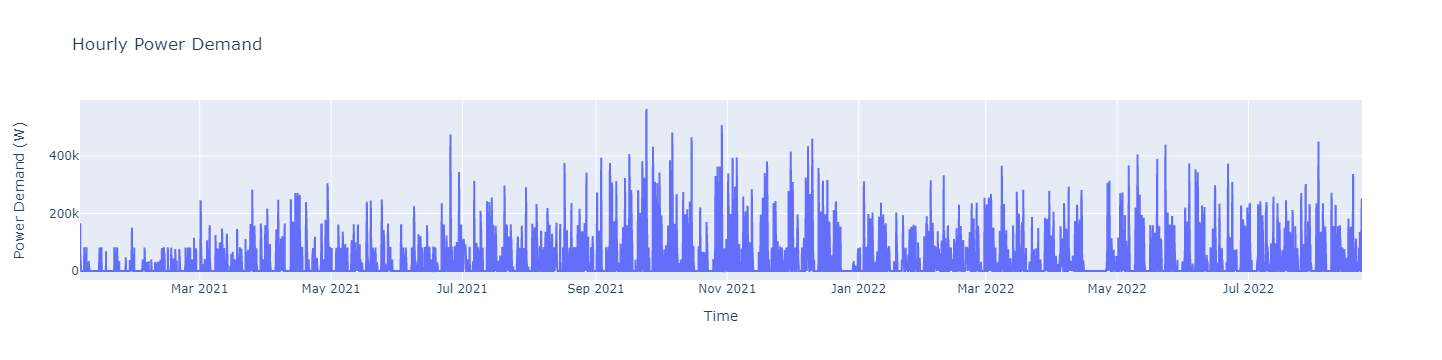

In [134]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = hourly_power_demand_df.index  , y = hourly_power_demand_df["power_demand"], hovertext=hourly_power_demand_df["day"]))
fig.update_layout(title = f"Hourly Power Demand", xaxis_title = "Time", yaxis_title="Power Demand (W)")
fig.show()

## Feature Engineering 

We can code up past hourly values as features; for example, a `lag1` column will have the previous day's power consumption at the same hour, a `lag2` column will have two day ago's power consumption at the same hour, etc.

`lag"N"` values will be the record from `N` days ago.

Depending on our depth of lags, some columns will have `NaN` as a value, as previous records don't exist. Let's drop those records. 

In [214]:
num_lag_depths = 30
for lag_depth in np.arange(1,num_lag_depths+1):
    hourly_power_demand_df["lag" + f"{lag_depth}"] = hourly_power_demand_df["power_demand"].shift(24*lag_depth)

hourly_power_demand_df.dropna(inplace=True)
hourly_power_demand_df.head()

power_demand        day  Monday  Tuesday  Wednesday  \
time                                                                       
2021-02-03 10:00:00         70413  Wednesday     0.0      0.0        1.0   
2021-02-03 11:00:00             0  Wednesday     0.0      0.0        1.0   
2021-02-03 12:00:00             0  Wednesday     0.0      0.0        1.0   
2021-02-03 13:00:00             0  Wednesday     0.0      0.0        1.0   
2021-02-03 14:00:00             0  Wednesday     0.0      0.0        1.0   

                     Thursday  Friday  Saturday  Sunday  Federal Holiday  ...  \
time                                                                      ...   
2021-02-03 10:00:00       0.0     0.0       0.0     0.0                0  ...   
2021-02-03 11:00:00       0.0     0.0       0.0     0.0                0  ...   
2021-02-03 12:00:00       0.0     0.0       0.0     0.0                0  ...   
2021-02-03 13:00:00       0.0     0.0       0.0     0.0                0  ...   
2021-02-03 14:00:00       0.0     0.0       0.0     0.0                0  ...   

                     lag51  lag52  lag53  lag54  lag55  lag56    lag57  \
time                                                                     
2021-02-03 10:00:00    0.0    0.0    0.0    0.0    0.0    0.0  82061.0   
2021-02-03 11:00:00    0.0    0.0    0.0    0.0    0.0    0.0  71025.0   
2021-02-03 12:00:00    0.0    0.0    0.0    0.0    0.0    0.0    381.0   
2021-02-03 13:00:00    0.0    0.0    0.0    0.0    0.0    0.0      0.0   
2021-02-03 14:00:00    0.0    0.0    0.0    0.0    0.0    0.0      0.0   

                       lag58  lag59  lag60  
time                                        
2021-02-03 10:00:00  63502.0    0.0    0.0  
2021-02-03 11:00:00  77396.0    0.0    0.0  
2021-02-03 12:00:00  84187.0    0.0    0.0  
2021-02-03 13:00:00  84117.0    0.0    0.0  
2021-02-03 14:00:00  84470.0    0.0    0.0  

[5 rows x 72 columns]

## Train / Test Split

Let's split our data in a way that doesn't violate the temporality of our data. Specifically we shouldn't have test data whose time index comes *before* our training data's time index.

In [215]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hourly_power_demand_df.drop(columns=["power_demand", "day", 
                                                                                           "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday", 
                                                                                           "Federal Holiday", "Academic Break", "Max Connected Users"]),
                                                    hourly_power_demand_df[["power_demand"]], test_size=0.2, shuffle=False) # shuffle is False 


## Applied Algorithms

Here, our output is the prediction energy consumption for the next 24 hours. 


$\large y(t) = E(t)$

The input is the concatenation of the consumption history for $D$ previous days.

$\large x(t) = \{E(t-24),E(t-48),\dots,E(t-24D)\}$

### Historical Average

This algorithm is extremely simple used only a baseline to compare model accuracy. With the historical average approach the power consumption at time $t$, $\hat{E}(t)$ is predicted using the average of the past $D$ energy consumption records. Formally, 

$\large \hat{E}(t) = \frac{1}{D} \sum\limits_{D}^{d = 1} E(t - 24d)$

Here, $D$ is the depth of averaging, which is a parameter to be tuned.

For example, using $D = 7$, to estimate the energy consumption tomorrow at 9 AM, we would take the average of the past 7 days' energy consumption at 9 PM.

In [216]:
def historical_average(df, averaging_depth):
    """This function takes in a dataframe, and depth of averaging, and returns new dataframe containing a datetime index
    and predicted power demand, based on the historical average algorithm. Dataframe must have a datetime index, 
    a "power_demand" column, and "lagN" columns, where a "lagN" column is the record from N days ago, at the same time."""
    # copy dataframe
    df_predictions = df.copy(deep = True)
    
    # select only lag columns up to averaging depth
    df_predictions = df_predictions[["lag" + f"{lag_depth}" for lag_depth in np.arange(1, averaging_depth+1)]] 
    
    # average across each row 
    df_predictions["prediction_average_algo"] = df_predictions.mean(axis = 1) 
    
    # return datetime index and associated predictions
    return df_predictions[["prediction_average_algo"]]


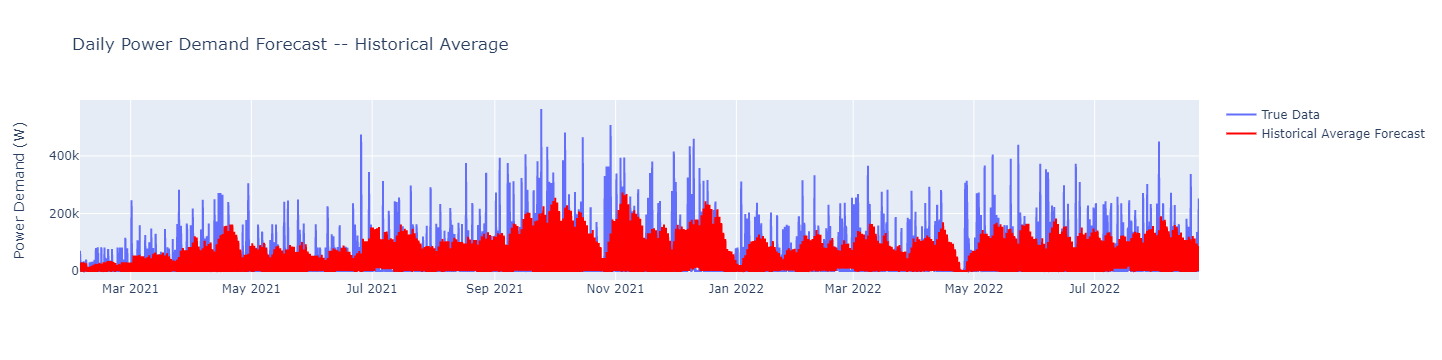

Test Set RMSE: 56136.99925668504 Watts


In [218]:
averaging_depth = 9
predictions_avg_algo_df = historical_average(hourly_power_demand_df, averaging_depth)
rmse = mean_squared_error(y_true=hourly_power_demand_df["power_demand"], y_pred=predictions_avg_algo_df["prediction_average_algo"], squared=False)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = hourly_power_demand_df["power_demand"].index , y = hourly_power_demand_df["power_demand"], name = "True Data", hovertext=hourly_power_demand_df["day"])
)
fig.add_trace(
    go.Scatter(x = predictions_avg_algo_df.index, y = predictions_avg_algo_df["prediction_average_algo"] , name = "Historical Average Forecast" , line= {"color":"red"})
)

fig.update_layout({"title" : "Daily Power Demand Forecast -- Historical Average" , "yaxis_title" : "Power Demand (W)"})
fig.show()
print(f"Test Set RMSE: {rmse} Watts")

### k-Nearest Neighbors

*k*-Nearest Neighbors is a supervised machine learning algorithm used for classification and regression. The algorithm calculates the *k* closest training example in a data set. The output is either class membership or the average of all *k* nearest neighbors. Note that different similarity metrics are used, with the most common being Euclidean distance.

Below is a high level summary of the *k*-NN algorithm.

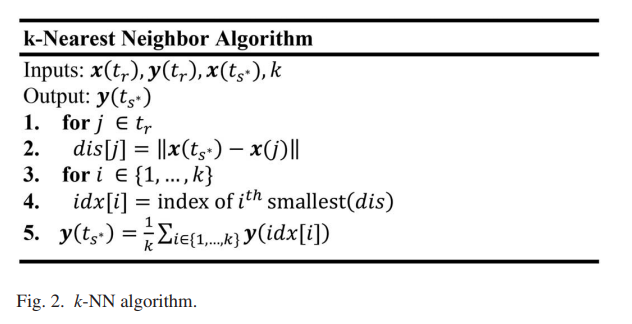


In plain English:

1. For every data point in your training set,
2. Store the distance between the test point and every point in the training set.
3. For the integers 1 to *k*,
4. Store the *k*th nearest datapoint from the training set to the test point.
5. Compute the average of the *k* training set records closest to the test point. Use this value for your prediction. 

The most common distance metric is Euclidean distance, which in 2-D space is the shortest path between two points. Here Euclidean distance is generalized for N-D space:

$$\sqrt{{(x1-y1)}^2 + {(x2-y2)}^2 + \dots + {(xN-yN)}^2}$$

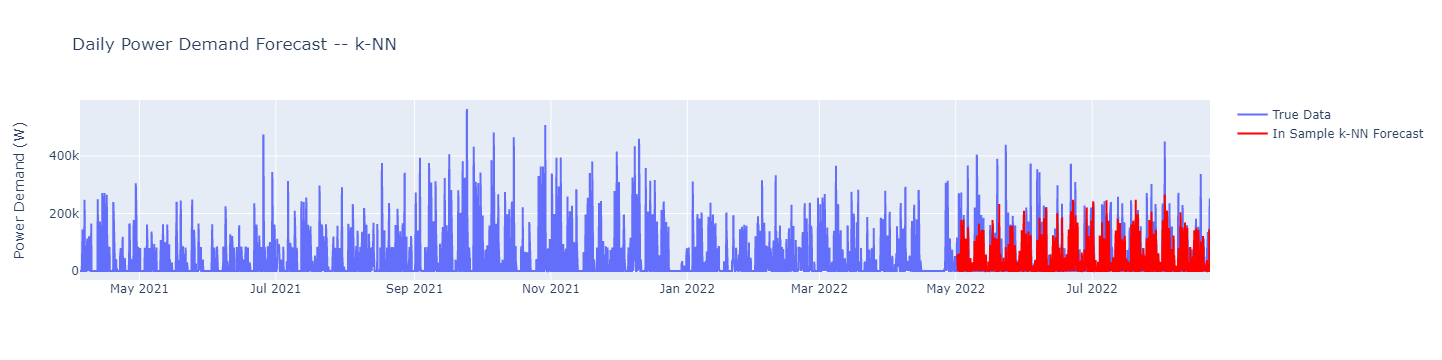

Test Set RMSE: 57916.06271093927 Watts


In [223]:
from sklearn.neighbors import KNeighborsRegressor

kNNRegressor = KNeighborsRegressor()
kNNRegressor.fit(X_train, y_train)
kNNpredictions = kNNRegressor.predict(X_test)

rmse = mean_squared_error(y_true=y_test, y_pred=kNNpredictions, squared=False)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = hourly_power_demand_df["power_demand"].index , y = hourly_power_demand_df["power_demand"], name = "True Data", hovertext=hourly_power_demand_df["day"])
)
fig.add_trace(
    go.Scatter(x = pd.DataFrame(index=y_test.index, data=kNNpredictions).index, y = pd.DataFrame(index=y_test.index, data=kNNpredictions)[0] , name = "In Sample k-NN Forecast" , line= {"color":"red"})
)

fig.update_layout({"title" : "Daily Power Demand Forecast -- k-NN" , "yaxis_title" : "Power Demand (W)"})
fig.show()
print(f"Test Set RMSE: {rmse} Watts")

### Weighted *k*-Nearest Neighbors

Weighted *k*-Nearest Neighbors is a variant on the traditional *k*-Nearest Neighbors algorithm, with the main change that points closer to the query point should contribute more to the final prediction.

Instead of averaging the *k* closest training outputs, their weighted average is used, where the weights are a function of the similarity between input pairs.

The weights are defined based on Dudani's weights, which arrive at bettery results, according to the literature. 

In the above figure, the following steps are replaced with step 5:

$\Large w_p = \frac{\mathrm{dis}[k+1] - \mathrm{dis}[p]}{\mathrm{dis}[k+1] - \mathrm{dis}[1]}, \hspace{1cm} p = 1,\dots,k$

where $\mathrm{dis}[p]$ is the distance of the $p$-th nearest neighbor to the query point, $\mathrm{dis}[1]$ is the distance of the nearest neighbor, and $\mathrm{dis}[k+1]$ is the distance of the $k$-th nearest neighbor. $\mathrm{dis}$ is assumed to be sorted in increasing order.

$\Large y(t_{s^*}) = \frac{1}{\sum_{q \in idx}w_q} \sum_{p \in idx}w_p y(p)$

Something to think about: a custom weighted measurement that places more emphasis weekend if weekend, and weekday if weekday.